# VIX v/s HV

El VIX toma expectativas anualizadas de 30 días, mientras que la volatilidad histórica o realizada (HV) vendría a ser la desviación estándar de los retornos del S&P 500 (SPX). Hay muchas maneras de calcular volatilidad histórica, pero utilizando precios de cierre, retornos logarítmicos y desviación estandar, es la metodología más aceptada. Normalemnte el cálculo de HV toma una ventana de 20 retornos logarítmicos hacia atrás (por eso es histórica), en este caso, tomaremos los 20  retornos siguientes, es decir expectativas de 1 mes v/s lo que ocurre realmente en ese mes (1 mes = 20 días de trading).

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

#### 1. Obteniendo datos

In [24]:
assets = ['^SPX', '^VIX']
df = pdr.get_data_yahoo(assets, period='max')['Adj Close'].dropna().reset_index()

[*********************100%***********************]  2 of 2 completed


#### 2. Calcular HV

In [25]:
# retornos logarítmicos
df['log returns'] = np.log(df['^SPX']/df['^SPX'].shift())

# HV de los próximos 20 días (1 mes) anualizada
df['HV+20d'] = df['log returns'].shift(-20).rolling(20).std() *np.sqrt(252) *100
df = df.dropna()
df

,Date,^SPX,^VIX,log returns,HV+20d
19,1990-01-29,325.200012,26.440001,-0.001843,13.473178
20,1990-01-30,322.980011,27.250000,-0.006850,13.235857
21,1990-01-31,329.079987,25.360001,0.018710,11.563902
22,1990-02-01,328.790009,24.870001,-0.000882,11.874632
23,1990-02-02,330.920013,24.320000,0.006457,11.898533
...,...,...,...,...,...
8453,2023-07-24,4554.640137,13.910000,0.004026,10.342614
8454,2023-07-25,4567.459961,13.860000,0.002811,10.206601
8455,2023-07-26,4566.750000,13.190000,-0.000155,11.193246
8456,2023-07-27,4537.410156,14.410000,-0.006445,11.876722


#### 3. VIX v/s HV

In [26]:
# diferencia entre VIX y HV
df['dif VIX-HV'] = df['^VIX'] - df['HV+20d']

# crear una columna para indicar si HV > VIX, esto creará datos booleanos
df['HV>VIX'] = df['HV+20d'] > df['^VIX']

# filtrar datos entre 2012 y 2022
inicio = '2012-01-01'
fin = '2022-12-31'

df = df[(df['Date']>=inicio) & (df['Date']<=fin)]
df

,Date,^SPX,^VIX,log returns,HV+20d,dif VIX-HV,HV>VIX
5547,2012-01-03,1277.060059,22.969999,0.015355,7.458749,15.511250,False
5548,2012-01-04,1277.300049,22.219999,0.000188,7.439544,14.780455,False
5549,2012-01-05,1281.060059,21.480000,0.002939,8.689955,12.790044,False
5550,2012-01-06,1277.810059,20.629999,-0.002540,8.560880,12.069119,False
5551,2012-01-09,1280.699951,21.070000,0.002259,8.562321,12.507679,False
...,...,...,...,...,...,...,...
8310,2022-12-23,3844.820068,20.870001,0.005851,16.820511,4.049489,False
8311,2022-12-27,3829.250000,21.650000,-0.004058,16.925380,4.724619,False
8312,2022-12-28,3783.219971,22.139999,-0.012093,15.973222,6.166777,False
8313,2022-12-29,3849.280029,21.440001,0.017311,16.166845,5.273155,False


#### 4. Estudios

In [27]:
# obetiendo el porcentaje de veces que HV+20d fue mayor que VIX
pctTrue = (df['HV>VIX'].value_counts(normalize=True) *100).round(2)
print(pctTrue)

False    81.61
True     18.39
Name: HV>VIX, dtype: float64


Entre 2012 y 2022 solo en el 18% de las ocaciones VH+20d anualizada fue mayor que el VIX, por ende, en el 82% de las veces el VIX exagerá lo que ocurre realmente con la volatilidad del SPX. 

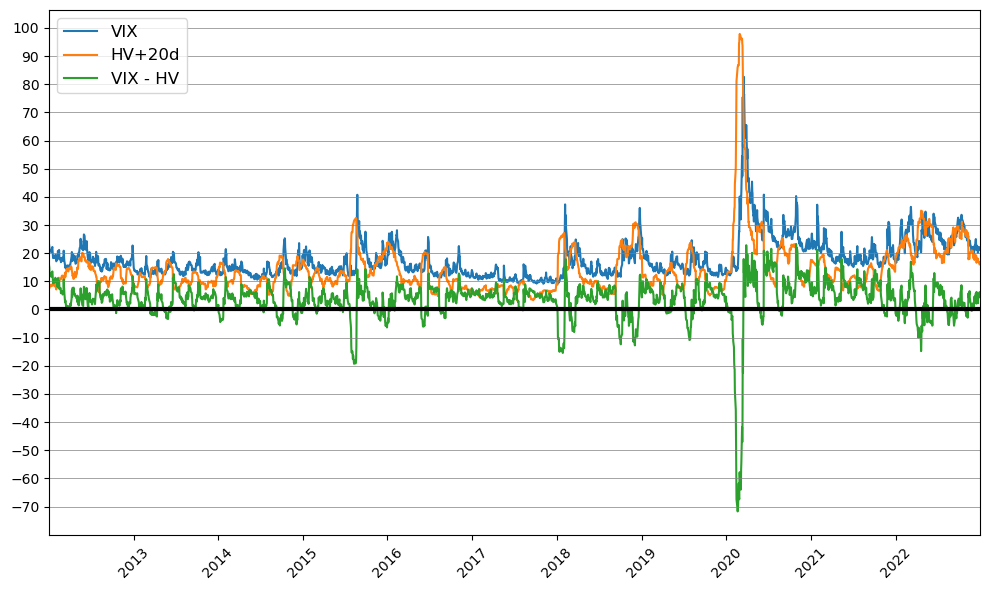

In [28]:
# graficar volatilidades y su diferencial
date = df['Date']
vix = df['^VIX']
hv = df['HV+20d']
dif = df['dif VIX-HV']

plt.figure(figsize=(10, 6))  
plt.plot(date, vix, label='VIX')
plt.plot(date, hv, label='HV+20d')
plt.plot(date, dif, label='VIX - HV')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# personalizar eje X e Y
plt.xticks(rotation=45)
plt.yticks(range(-70, 101, 10))

# líneas horizontales en el gráfico
for y in range(-70, 101, 10):
    plt.axhline(y, color='gray', linestyle='-', linewidth=0.5)

plt.axhline(y=0, linestyle='-', linewidth=3, color='black')

plt.legend(loc=2, fontsize=12) 

plt.margins(x=0)

plt.tight_layout()
plt.show()

Centremonos en el diferencial VIX - HV, veamos esta distribución en profundidad, para ello, primero realizaremos algunos ajustes de los datos de la columna 'dif VIX-HV' para facilitar la visualización.

In [29]:
# aproximando los valores a su número entero más cercano (o redondearemos)
ptsDif = df['dif VIX-HV'].round()
ptsDif = ptsDif.apply(lambda x: 0 if x == -0.0 else x)
ptsDif = ptsDif.astype(int)
ptsDif.describe()

count    2768.000000
mean        3.487717
std         7.757799
min       -72.000000
25%         1.000000
50%         4.000000
75%         7.000000
max        23.000000
Name: dif VIX-HV, dtype: float64

In [31]:
# agruparemos los valores extremos, ya que tienen poca frecuencia.
def transform_value(value):
    if value > 14:
        return 15 # valores mayores a 14 serán todos 15
    elif value < -14:
        return -15 # valores menores a -14 serán todos -15
    return value

ptsDif = ptsDif.apply(transform_value)

# crear nuevo dataframe que contenga valores enteros y agrupado de 'dif VIX-HV', y su respectiva distribución o frecuencia
frecPts = pd.DataFrame(ptsDif.value_counts().sort_index()).reset_index()
frecPts.rename(columns = {'index':'dif VIX-HV', 'dif VIX-HV':'frecuencia'}, inplace = True)
frecPts['porcentaje'] = frecPts['frecuencia']/frecPts['frecuencia'].sum()    
frecPts

,dif VIX-HV,frecuencia,porcentaje
0,-15,50,0.018064
1,-14,7,0.002529
2,-13,5,0.001806
3,-12,3,0.001084
4,-11,9,0.003251
5,-10,18,0.006503
6,-9,10,0.003613
7,-8,10,0.003613
8,-7,10,0.003613
9,-6,30,0.010838


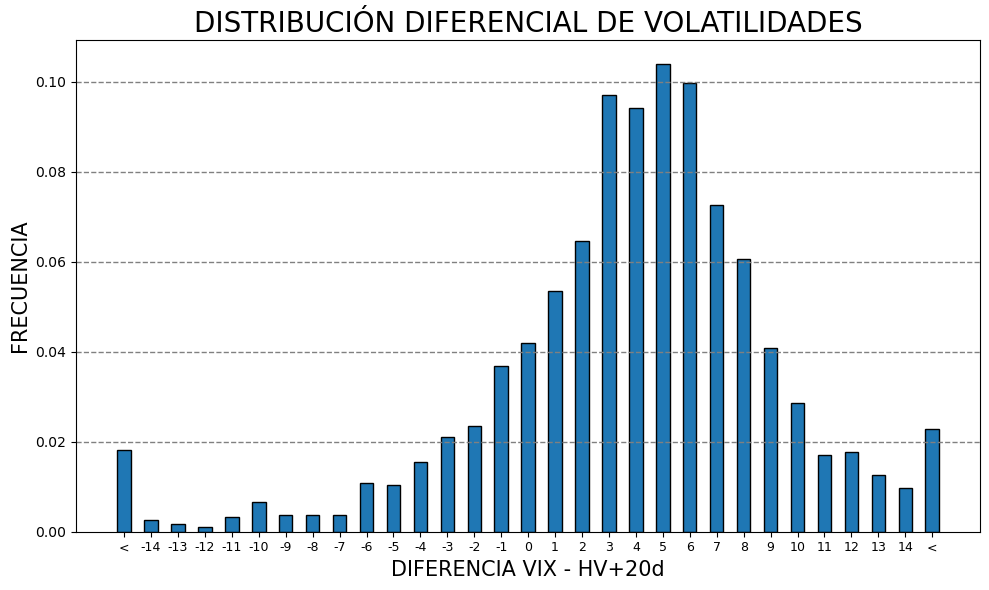

In [37]:
# plot en gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(frecPts['dif VIX-HV'], frecPts['porcentaje'], edgecolor='black', width=0.5)

x_labels = ['<', '-14', '-13', '-12', '-11', '-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '<',]
plt.xticks(frecPts['dif VIX-HV'], x_labels, fontsize=9)
plt.xticks(fontsize=9)

plt.title('DISTRIBUCIÓN DIFERENCIAL DE VOLATILIDADES', fontsize=20)
plt.xlabel('DIFERENCIA VIX - HV+20d', fontsize=15)
plt.ylabel('FRECUENCIA', fontsize=15)

y_values = [0.02, 0.04, 0.06, 0.08, 0.10]
for y in y_values:
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

Nos podemos dar cuenta gracias al gráfico que el diferencial VIX - HV+20d se agrupa mayormente entre 3 y 6 puntos, cerca del 40% de los datos están dentro de este rango. Si ampliamos el rango, podriamos decir que cerca del 60% del diferencial se encuantra entre 2 y 7 puntos.